In [314]:
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy
import torch
import librosa
from speechbrain.processing.signal_processing import (
    gabor_impulse_response,
    gabor_impulse_response_legacy_complex,
)

import student
import teacher
import utils
from tabulate import tabulate

models_dir = "/Users/Dane/Documents/Python/waspaa2023_filterbanks/models"
domain = "music"

T = 2**12

In [315]:
arch = "TDFilterbank"
init_id = 0
constructor = getattr(student, arch)

subfolder = os.path.join(
    models_dir,
    domain,
    f"main,domain-{domain},arch-{arch},init_id-{init_id}"
)
ckpt_path = os.path.join(subfolder, "best.ckpt")
spec = teacher.HYPERPARAMS[domain]

conv_model = constructor.load_from_checkpoint(ckpt_path, spec=spec)

psi_real = conv_model.psi_real.weight.detach().numpy()[:, 0, :]
psi_imag = conv_model.psi_imag.weight.detach().numpy()[:, 0, :]
conv_imp = psi_real + 1j * psi_imag
conv_imp = conv_imp[1:,:] # unlearned lowpass filter is removed
conv_imp = np.pad(conv_imp, ((0,0),((T-conv_imp.shape[-1]+1)//2, (T-conv_imp.shape[-1])//2)))
psi_abs = np.abs(conv_imp)

In [316]:
conv_imp.shape

(95, 4096)

In [318]:
# Murenn

arch = "MuReNN"
subfolder = os.path.join(
    models_dir,
    domain,
    f"main,domain-{domain},arch-{arch},init_id-{init_id}"
)
ckpt_path = os.path.join(subfolder, "best.ckpt")
spec = teacher.HYPERPARAMS[domain]
constructor = getattr(student, arch)

murenn_model = constructor.load_from_checkpoint(ckpt_path, spec=spec)

# simulate impulse response

dirac = torch.zeros((1, 1, 1024))
dirac[0, 0, 16] = 1.0
_, x_levels = murenn_model.tfm(dirac)
J = len(x_levels)
k = 0

murenn_imp = []

for j,j_psi in enumerate(range(J)):
    for k in range(murenn_model.psis[j_psi].out_channels):
        x_level = x_levels[j_psi].type(torch.complex64)
        murenn_psi = murenn_model.psis[j_psi]
        murenn_psi.stride = 1
        y_real = murenn_psi(x_level.real)[0, k, :]
        y_imag = murenn_psi(x_level.imag)[0, k, :]
        y = y_real + 1j * y_imag
        y = y.detach().numpy()
        y = scipy.signal.resample(y, (2**j_psi)*len(y))
        murenn_imp.append(np.pad(y, ((T-len(y)+1)//2, (T-len(y))//2)))
murenn_imp = np.array(murenn_imp)

In [319]:
murenn_imp.shape

(95, 4096)

In [198]:
# LEAF

import copy

arch = "Gabor1D"
init_id = 0
constructor = getattr(student, arch)

subfolder = os.path.join(
    models_dir,
    domain,
    f"main,domain-{domain},arch-{arch},init_id-{init_id}"
)
ckpt_path = os.path.join(subfolder, "best.ckpt")

old_ckpt = torch.load(ckpt_path)
new_ckpt = copy.deepcopy(old_ckpt)
new_ckpt['state_dict'] = {'gaborfilter.kernel': old_ckpt['state_dict']['gaborfilter.kernel'], 'learnable_scaling.weight': old_ckpt['state_dict']['learnable_scaling.parametrizations.weight.original']}
torch.save(new_ckpt, os.path.join(subfolder, "best_mod.ckpt"))

ckpt_path = os.path.join(subfolder, "best_mod.ckpt")

spec = teacher.HYPERPARAMS[domain]

leaf_model = constructor.load_from_checkpoint(ckpt_path, spec=spec)

kernel = leaf_model.gaborfilter.kernel.float()
t = torch.arange(-(T // 2),(T + 1) // 2).float()
leaf_imp = gabor_impulse_response(t, center = kernel[:, 0], fwhm = kernel[:, 1])
leaf_imp = leaf_imp.detach().numpy()
leaf_imp = leaf_imp[1:,:] # unlearned lowpass filter is removed

In [199]:
leaf_imp.shape

(95, 4096)

In [320]:
# save the impulse responses

#np.save("conv_imp_music.npy", conv_imp)
#np.save("murenn_imp_music.npy", murenn_imp)
#np.save("leaf_imp_music.npy", leaf_imp)

In [205]:
# get frequency responses

def get_fr(imp, complex = True):
    """
    in: impulse responses (channels, time)
    out: frequency reponses (time, channels)
    """
    fr = np.fft.fft(imp,axis=1)/np.sqrt(imp.shape[1])
    if complex:
        return fr.T
    return np.real(fr.T), np.imag(fr.T)

In [207]:
def frame_bounds_polyphase(freqz, stride, length, imp = False):
    """
    in: frequency responses of fb (nfft, n_filters) or with imp = True: impulse responses (n_filters, nfft) + specifying target length

    """
    if imp == True:
        #imp_pad = np.pad(freqz, ((0,0),(0,length-freqz.shape[1])), 'constant', constant_values = 0)
        fr = get_fr(freqz, complex = True)
        fr = np.abs(fr)
    if imp == False:
        fr = np.abs(freqz)
    N = fr.shape[0]
    M = fr.shape[1]
    G = fr
    a = stride
    A = np.inf
    B = 0
    Ha = np.zeros((a,M))
    Hb = np.zeros((a,M))
    assert np.mod(N,a) == 0

    for w in range(N):
        idx_a = np.mod(w - np.arange(a)*N//a, N).astype(int)
        idx_b = np.mod(np.arange(a)*N//a - w, N).astype(int)
        Ha = G[idx_a, :]
        Hb = np.conj(G[idx_b, :])
        work = np.real(np.linalg.eigvalsh(np.real(Ha @ Ha.T + Hb @ Hb.T)))
        A = np.min([A, np.min(work)])
        B = np.max([B, np.max(work)])
    return A/a, B/a

In [393]:
import pickle

with open('Freqz/VQT.pkl', 'rb') as fp:
    VQT = pickle.load(fp)
teacher_fr_music = VQT['freqz']
teacher_fr_music_lp = teacher_fr_music[:,0][:,np. newaxis]

with open('Freqz/GAM.pkl', 'rb') as fp:
    GAM = pickle.load(fp)
teacher_fr_speech = GAM['freqz']
teacher_fr_speech_lp = teacher_fr_speech[:,0][:,np. newaxis]

with open('Freqz/THIRD.pkl', 'rb') as fp:
    THIRD = pickle.load(fp)
teacher_fr_urban = THIRD['freqz']
teacher_fr_urban_lp = teacher_fr_urban[:,0][:,np. newaxis]

In [334]:
#### Music

# Impulse responses

conv_imp_music = np.load("Freqz/conv_imp_music.npy")
murenn_imp_music = np.load("Freqz/murenn_imp_music.npy")
leaf_imp_music = np.load("Freqz/leaf_imp_music.npy")

# Frequency responses + add LPF

conv_fr_music = get_fr(conv_imp_music, complex = True)
conv_fr_music = np.append(teacher_fr_music_lp, conv_fr_music, axis = 1)
conv_fr_music = conv_fr_music / np.max(np.abs(conv_fr_music), axis=0) * 4
murenn_fr_music = get_fr(murenn_imp_music, complex = True)
murenn_fr_music = np.append(teacher_fr_music_lp, murenn_fr_music, axis = 1)
murenn_fr_music = murenn_fr_music / np.max(np.abs(murenn_fr_music), axis=0) * 4
leaf_fr_music = get_fr(leaf_imp_music, complex = True)
leaf_fr_music = np.append(teacher_fr_music_lp, leaf_fr_music, axis = 1)
leaf_fr_music = leaf_fr_music / np.max(np.abs(leaf_fr_music), axis=0) * 4

#### Speech

# Impulse responses

conv_imp_speech = np.load("Freqz/conv_imp_speech.npy")
murenn_imp_speech = np.load("Freqz/murenn_imp_speech.npy")
leaf_imp_speech = np.load("Freqz/leaf_imp_speech.npy")

# Frequency responses + add LPF

conv_fr_speech = get_fr(conv_imp_speech, complex = True)
conv_fr_speech = np.append(teacher_fr_speech_lp, conv_fr_speech,axis = 1)
conv_fr_speech = conv_fr_speech / np.max(np.abs(conv_fr_speech), axis=0) * 2
murenn_fr_speech = get_fr(murenn_imp_speech, complex = True)
murenn_fr_speech = np.append(teacher_fr_speech_lp, murenn_fr_speech,axis = 1)
murenn_fr_speech = murenn_fr_speech / np.max(np.abs(murenn_fr_speech), axis=0) * 2
leaf_fr_speech = get_fr(leaf_imp_speech, complex = True)
leaf_fr_speech = np.append(teacher_fr_speech_lp, leaf_fr_speech,axis = 1)
leaf_fr_speech = leaf_fr_speech / np.max(np.abs(leaf_fr_speech), axis=0) * 2

#### Urban

# Impulse responses

conv_imp_urban = np.load("Freqz/conv_imp_urban.npy")
murenn_imp_urban = np.load("Freqz/murenn_imp_urban.npy")
leaf_imp_urban = np.load("Freqz/leaf_imp_urban.npy")

# Frequency responses + add LPF

conv_fr_urban = get_fr(conv_imp_urban, complex = True)
conv_fr_urban = np.append(teacher_fr_urban_lp, conv_fr_urban,axis = 1)
conv_fr_urban = conv_fr_urban / np.max(np.abs(conv_fr_urban), axis=0) * 2
murenn_fr_urban = get_fr(murenn_imp_urban, complex = True)
murenn_fr_urban = np.append(teacher_fr_urban_lp, murenn_fr_urban,axis = 1)
murenn_fr_urban = murenn_fr_urban / np.max(np.abs(murenn_fr_urban), axis=0) * 2
leaf_fr_urban = get_fr(leaf_imp_urban, complex = True)
leaf_fr_urban = np.append(teacher_fr_urban_lp, leaf_fr_urban,axis = 1)
leaf_fr_urban = leaf_fr_urban / np.max(np.abs(leaf_fr_urban), axis=0) * 2


In [335]:
stride_music = 1
stride_speech = 1
stride_urban = 1

A_murenn_music, B_murenn_music = frame_bounds_polyphase(murenn_fr_music, stride_music, 2**12)
A_murenn_speech, B_murenn_speech = frame_bounds_polyphase(murenn_fr_speech, stride_speech, 2**12)
A_murenn_urban, B_murenn_urban = frame_bounds_polyphase(murenn_fr_urban, stride_urban, 2**12)

A_conv_music, B_conv_music = frame_bounds_polyphase(conv_fr_music, stride_music, 2**12)
A_conv_speech, B_conv_speech = frame_bounds_polyphase(conv_fr_speech, stride_speech, 2**12)
A_conv_urban, B_conv_urban = frame_bounds_polyphase(conv_fr_urban, stride_urban, 2**12)

A_leaf_music, B_leaf_music = frame_bounds_polyphase(leaf_fr_music, stride_music, 2**12)
A_leaf_speech, B_leaf_speech = frame_bounds_polyphase(leaf_fr_speech, stride_speech, 2**12)
A_leaf_urban, B_leaf_urban = frame_bounds_polyphase(leaf_fr_urban, stride_urban, 2**12)

A_vqt_music, B_vqt_music = frame_bounds_polyphase(teacher_fr_music, stride_music, 2**12)
A_gam_speech, B_gam_speech = frame_bounds_polyphase(teacher_fr_speech, stride_speech, 2**12)
A_third_urban, B_third_urban = frame_bounds_polyphase(teacher_fr_urban, stride_urban, 2**12)

In [451]:
frame_bounds = [["Speech", B_gam_speech/A_gam_speech, B_conv_speech/A_conv_speech, B_leaf_speech/A_leaf_speech, B_murenn_speech/A_murenn_speech ], 
        ["Music", B_vqt_music/A_vqt_music, B_conv_music/A_conv_music, B_leaf_music/A_leaf_music, B_murenn_music/A_murenn_music,  ], 
        ["Urban",  B_third_urban/A_third_urban, B_conv_urban/A_conv_urban , B_leaf_urban/A_leaf_urban, B_murenn_urban/A_murenn_urban],
        ]

col_names = ["Model", "Teacher", "Conv1D", "Gabor1D", "MuReNN"]

print(tabulate(frame_bounds, headers=col_names))

Model      Teacher    Conv1D      Gabor1D    MuReNN
-------  ---------  --------  -----------  --------
Speech     1.54376   9.83884  8.9698e+13    864.426
Music      5.00326  82.8442   3.2126e+08   3394.02
Urban      5.66278  10.655    2.65379e+08  1309.95


/var/folders/db/yfsdb4xd5ll9f3rft6p5y0380000gp/T/ipykernel_2242/1691373125.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0,0].set_xlim([0, 8000])
/var/folders/db/yfsdb4xd5ll9f3rft6p5y0380000gp/T/ipykernel_2242/1691373125.py:19: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0,1].set_xlim([0, 22050])
/var/folders/db/yfsdb4xd5ll9f3rft6p5y0380000gp/T/ipykernel_2242/1691373125.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0,2].set_xlim([0, 22050])
/var/folders/db/yfsdb4xd5ll9f3rft6p5y0380000gp/T/ipykernel_2242/1691373125.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1,0].set_xlim([0, 8000])
/var/folders/db/yfsdb4xd5ll9f3rft6p5y0380000gp/T/ipykernel_2242/1691373125.py:37: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1,1].set_xlim([0, 22050])
/var/folders/db/y

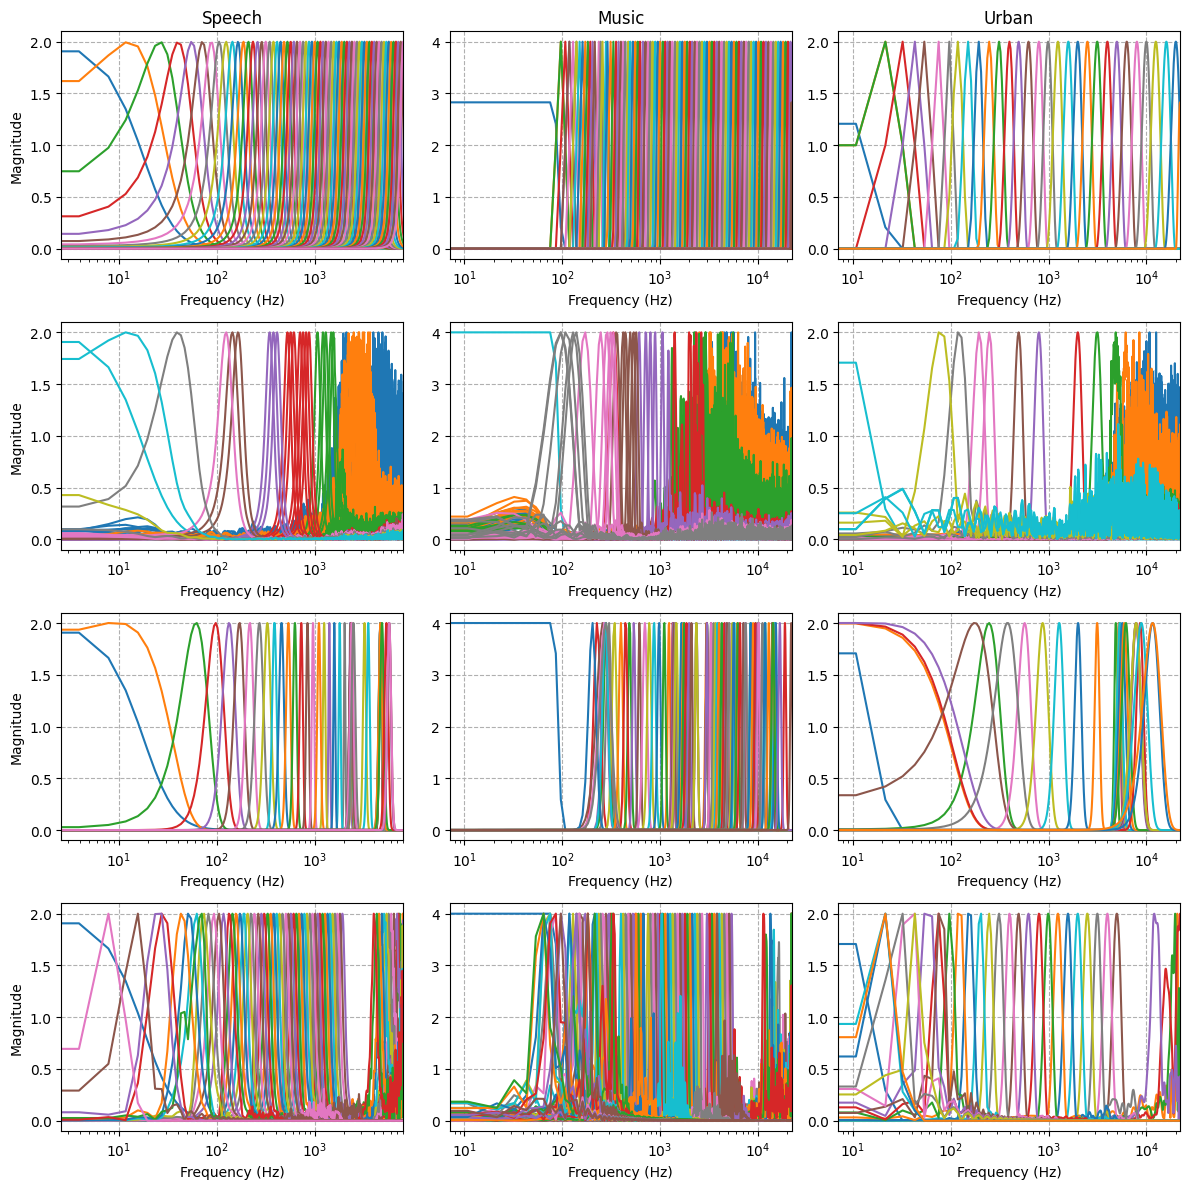

In [445]:
from matplotlib import pyplot

omega = np.linspace(0, 44100, 2**12)
omega_speech = np.linspace(0, 16000, 2**12)
oct_music = VQT["octave_tags"]
oct_speech = GAM["octave_tags"]
oct_urban = THIRD["octave_tags"]

col = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(4, 3, sharex = False,figsize=(12, 12))

ax[0,0].semilogx(omega_speech,np.abs(teacher_fr_speech[:,:]))
ax[0,1].semilogx(omega,np.abs(teacher_fr_music[:,:]))
ax[0,2].semilogx(omega,np.abs(teacher_fr_urban[:,:]))
ax[0,0].set_xlim([0, 8000])
ax[0,1].set_xlim([0, 22050])
ax[0,2].set_xlim([0, 22050])
ax[0,0].set_xlabel("Frequency (Hz)")
ax[0,0].set_ylabel("Magnitude")
ax[0,1].set_xlabel("Frequency (Hz)")
ax[0,2].set_xlabel("Frequency (Hz)")
ax[0,0].set_title("Speech")
ax[0,1].set_title("Music")
ax[0,2].set_title("Urban")
ax[0,0].grid(linestyle='--')
ax[0,1].grid(linestyle='--')
ax[0,2].grid(linestyle='--')

for j in range(-1,10):
    ax[1,0].semilogx(omega_speech,np.abs(conv_fr_speech[:,np.where(oct_speech == j)[1]]), color = col[j])
    ax[1,1].semilogx(omega,np.abs(conv_fr_music[:,np.where(oct_music == j)[1]]), color = col[j])
    ax[1,2].semilogx(omega,np.abs(conv_fr_urban[:,np.where(oct_urban == j)[1]]), color = col[j])
ax[1,0].set_xlim([0, 8000])
ax[1,1].set_xlim([0, 22050])
ax[1,2].set_xlim([0, 22050])
ax[1,0].set_xlabel("Frequency (Hz)")
ax[1,0].set_ylabel("Magnitude")
ax[1,1].set_xlabel("Frequency (Hz)")
ax[1,2].set_xlabel("Frequency (Hz)")
ax[1,0].grid(linestyle='--')
ax[1,1].grid(linestyle='--')
ax[1,2].grid(linestyle='--')

ax[2,0].semilogx(omega_speech,np.abs(leaf_fr_speech[:,:]))
ax[2,1].semilogx(omega,np.abs(leaf_fr_music[:,:]))
ax[2,2].semilogx(omega,np.abs(leaf_fr_urban[:,:]))
ax[2,0].set_xlim([0, 8000])
ax[2,1].set_xlim([0, 22050])
ax[2,2].set_xlim([0, 22050])
ax[2,0].set_xlabel("Frequency (Hz)")
ax[2,0].set_ylabel("Magnitude")
ax[2,1].set_xlabel("Frequency (Hz)")
ax[2,2].set_xlabel("Frequency (Hz)")
ax[2,0].grid(linestyle='--')
ax[2,1].grid(linestyle='--')
ax[2,2].grid(linestyle='--')

ax[3,0].semilogx(omega_speech,np.abs(murenn_fr_speech[:,:]))
ax[3,1].semilogx(omega,np.abs(murenn_fr_music[:,:]))
ax[3,2].semilogx(omega,np.abs(murenn_fr_urban[:,:]))
ax[3,0].set_xlim([0, 8000])
ax[3,1].set_xlim([0, 22050])
ax[3,2].set_xlim([0, 22050])
ax[3,0].set_xlabel("Frequency (Hz)")
ax[3,0].set_ylabel("Magnitude")
ax[3,1].set_xlabel("Frequency (Hz)")
ax[3,2].set_xlabel("Frequency (Hz)")
ax[3,0].grid(linestyle='--')
ax[3,1].grid(linestyle='--')
ax[3,2].grid(linestyle='--')


plt.tight_layout()
plt.savefig("Freqz/Plots/all_fr.png")
plt.show()

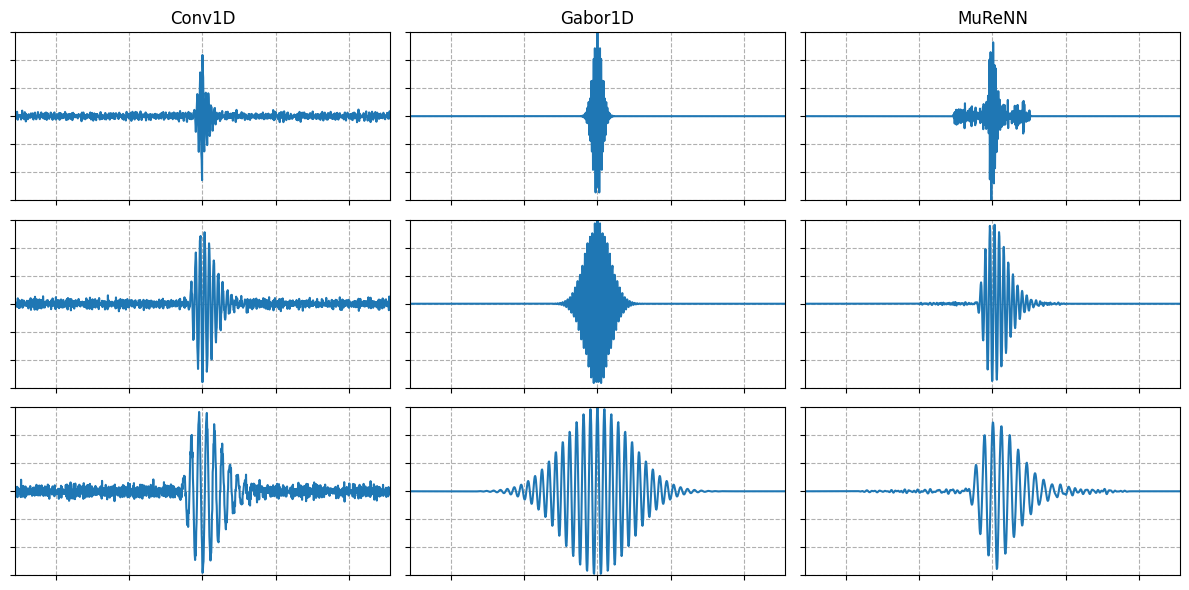

In [472]:
dirac = torch.zeros((1, 1, 1024))
dirac[0, 0, 512] = 1.0
_, x_levels = murenn_model.tfm(dirac)
J = len(x_levels)
k = 0
T = 2**12
t = np.arange(-T//2, T//2)

fig, ax = plt.subplots(3, 3, sharex=True,sharey = True,figsize=(12, 6))

for fig_id, j_psi in enumerate(range(2, 5)):
    # Conv1D
    #y = conv_imp[-j_psi*12 - 11, :] # probably wrong formula
    #y = conv_imp_music[(76-fig_id*14),:]
    y = conv_imp_speech[(42-fig_id*8),:]
    ax[fig_id, 0].plot(t, y / max(abs(y)))
    ax[fig_id, 0].set_ylim(-1, 1)
    ax[fig_id, 0].set_ylim(-1, 1)
    ax[fig_id, 0].set_yticks(np.linspace(-1, 1, 7, endpoint=True))
    ax[fig_id, 0].set_xlim(-512, 512)
    ax[fig_id, 0].set_xticklabels([])
    ax[fig_id, 0].set_yticklabels([])
    ax[fig_id, 0].grid(linestyle='--')
    ax[0, 0].set_title('Conv1D')
    
    # MuReNN
    #t = np.arange(-T//2, T//2)
    #x_level = x_levels[j_psi].type(torch.complex64)
    #murenn_psi = murenn_model.psis[j_psi]
    #murenn_psi.stride = 1
    #y_real = murenn_psi(x_level.real)[0, k, :]
    #y_imag = murenn_psi(x_level.imag)[0, k, :]
    #y = y_real + 1j * y_imag
    #y = y.detach().numpy()
    #y = scipy.signal.resample(y, (2**j_psi)*len(y))
    #y = np.pad(y, ((T-len(y))//2, (T-len(y))//2))
    #y = leaf_imp_music[(76-fig_id*24),:]
    y = leaf_imp_speech[(60-fig_id*23),:]
    ax[fig_id, 1].plot(t, y / max(abs(y)))
    ax[fig_id, 1].set_ylim(-1, 1)
    ax[fig_id, 1].set_yticks(np.linspace(-1, 1, 7, endpoint=True))
    ax[fig_id, 1].set_xlim(-512, 512)
    ax[fig_id, 1].set_xticklabels([])
    ax[fig_id, 1].set_yticklabels([])
    ax[fig_id, 1].grid(linestyle='--')
    ax[0, 1].set_title('Gabor1D')

    #y = murenn_imp_music[(fig_id+1)*12,:]
    y = np.flip(murenn_imp_speech[(fig_id+1)*10,:])
    ax[fig_id, 2].plot(t, y / max(abs(y)))
    ax[fig_id, 2].set_ylim(-1, 1)
    ax[fig_id, 2].set_yticks(np.linspace(-1, 1, 7, endpoint=True))
    ax[fig_id, 2].set_xlim(-512, 512)
    ax[fig_id, 2].set_xticklabels([])
    ax[fig_id, 2].set_yticklabels([])
    ax[fig_id, 2].grid(linestyle='--')
    ax[0, 2].set_title('MuReNN')

plt.tight_layout()
plt.savefig("Freqz/Plots/all_imp.png")
plt.show()

In [346]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Initialize model
constructor = getattr(student, "MuReNN")
spec = teacher.HYPERPARAMS[domain]
Murenn_init = constructor(spec)

# Setup checkpoints and Tensorboard logger
checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints",
    monitor="val_loss",
    save_last=True,
    filename="best",
    save_weights_only=False,
)

In [347]:
_, x_levels = Murenn_init.tfm(dirac)
J = len(x_levels)
k = 0

murenn_imp = []

for j,j_psi in enumerate(range(J)):
    for k in range(Murenn_init.psis[j_psi].out_channels):
        x_level = x_levels[j_psi].type(torch.complex64)
        murenn_psi = Murenn_init.psis[j_psi]
        murenn_psi.stride = 1
        y_real = murenn_psi(x_level.real)[0, k, :]
        y_imag = murenn_psi(x_level.imag)[0, k, :]
        y = y_real + 1j * y_imag
        y = y.detach().numpy()
        y = scipy.signal.resample(y, (2**j_psi)*len(y))
        murenn_imp.append(np.pad(y, ((T-len(y)+1)//2, (T-len(y))//2)))
murenn_imp = np.array(murenn_imp)
murenn_imp.shape

In [362]:
murenn_init_fr = get_fr(murenn_imp)
murenn_init_fr = np.append(teacher_fr_music_lp, murenn_init_fr, axis = 1)
murenn_init_fr = murenn_fr_music / np.max(np.abs(murenn_init_fr), axis=0)

/var/folders/db/yfsdb4xd5ll9f3rft6p5y0380000gp/T/ipykernel_2242/1966593746.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 22050])


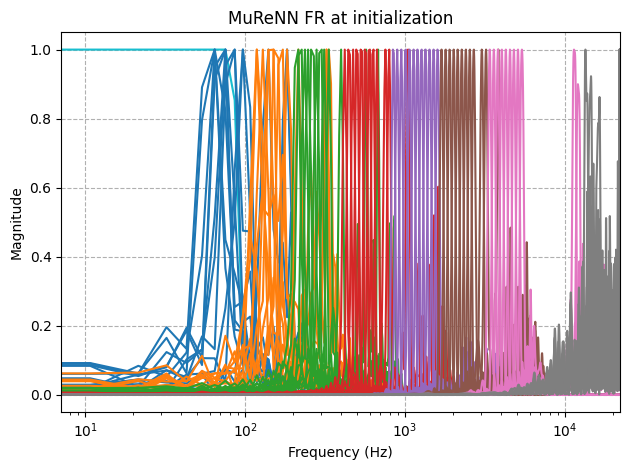

In [449]:
oct_music = VQT["octave_tags"]

col = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for j in range(-1,10):
    plt.semilogx(omega,np.abs(murenn_init_fr[:,np.where(oct_music == j)[1]])/ np.max(np.abs(murenn_init_fr[:,np.where(oct_music == j)[1]]), axis=0), color = col[j])

plt.xlim([0, 22050])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(linestyle='--')
plt.title("MuReNN FR at initialization")
plt.savefig("Freqz/Plots/murenn_init_fr.png")
plt.tight_layout()
plt.show()